# Response time minimization - Troms police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Troms police district
The police district comprises 18 municipalities in Troms and Finnmark counties. The district is organized into five police station districts/geographic operating units, with a total of ten police stations, as well as five functional operating units and three management support staffs. The head office is located in Tromsø.


In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-30T20:02:44.297744+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

osmnx     : 1.9.1
pandana   : 0.7
pandas    : 2.2.1
numpy     : 1.26.4
geopandas : 0.14.3
matplotlib: 3.8.3



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [3]:
### Load road network from file
Troms_filepath = "../data/Troms/TromsDriveImputed.graphml" # with travel time attribute
Troms_graph = ox.load_graphml(Troms_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
Troms_graph = ox.projection.project_graph(Troms_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Troms_graph: {type(Troms_graph)}")
print(f"CRS of Troms_graph:  {Troms_graph.graph['crs']}")

# # plot graph
# fig, ax = ox.plot_graph(Troms_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Troms_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Troms_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Troms_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u          v          key                                                      
5795532316 5795556879 0    [423928962, 66180591, 318402773, 612236920, 61...   
           5795532316 0                                            423928968   

                                highway  oneway reversed   length  \
u          v          key                                           
5795532316 5795556879 0    unclassified   False     True 6955.885   
           5795532316 0    unclassified   False    False  194.564   

                                    name  \
u          v          key                  
5795532316 5795556879 0    Dividalsveien   
           5795532316 0              NaN   

                                                                    geometry  \
u          v          key                                                      
5795532316 5795556879 0    LINESTRING (692311.830 7631157.736, 692299.021...   
           5795532316 0    LINESTRING (692311.830 7631157.736, 692312.361...   

                           speed_kph  travel_time  ref maxspeed bridge width  \
u          v          key                                                      
5795532316 5795556879 0       41.900      597.600  NaN      NaN    NaN   NaN   
           5795532316 0       41.900       16.700  NaN      NaN    NaN   NaN   

                          tunnel access lanes junction  
u          v          key                               
5795532316 5795556879 0      NaN    NaN   NaN      NaN  
           5795532316 0      NaN    NaN   NaN      NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [6]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid  \
u          v          key                                                      
5795532316 5795556879 0    [423928962, 66180591, 318402773, 612236920, 61...   
           5795532316 0                                            423928968   

                                highway  oneway reversed   length  \
u          v          key                                           
5795532316 5795556879 0    unclassified   False     True 6955.885   
           5795532316 0    unclassified   False    False  194.564   

                                    name  \
u          v          key                  
5795532316 5795556879 0    Dividalsveien   
           5795532316 0              NaN   

                                                                    geometry  \
u          v          key                                                      
5795532316 5795556879 0    LINESTRING (692311.830 7631157.736, 692299.021...   
           5795532316 0    LINESTRING (692311.830 7631157.736, 692312.361...   

                           speed_kph  travel_time  ref maxspeed bridge width  \
u          v          key                                                      
5795532316 5795556879 0       50.694      493.964  NaN      NaN    NaN   NaN   
           5795532316 0       50.694       13.817  NaN      NaN    NaN   NaN   

                          tunnel access lanes junction  
u          v          key                               
5795532316 5795556879 0      NaN    NaN   NaN      NaN  
           5795532316 0      NaN    NaN   NaN      NaN

In [7]:
# recombining nodes and increased edges to MultiDiGraph format
Troms_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [8]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Troms_polygon_path = "../data/Troms/TromsCombinedPolygon.geojson"
Troms_polygon_gdf = gpd.read_file(Troms_polygon_path)
Troms_polygon_gdf = Troms_polygon_gdf.to_crs(Troms_graph.graph['crs']) # convert to same CRS as the road network

In [9]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Troms/TromsPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Troms_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,25540007590250,8,"POLYGON ((554000.000 7590250.000, 554000.000 7..."
1,25557507590500,1,"POLYGON ((555750.000 7590500.000, 555750.000 7..."


### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [11]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=870, max_range=900) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 884. Target range [870, 900], using population multiplier: 0.008347656250000002


,id,population,geometry,num_points
7817,26535007732250,772,"POLYGON ((653500.000 7732250.000, 653500.000 7...",6
7501,26525007730000,626,"POLYGON ((652500.000 7730000.000, 652500.000 7...",5
7696,26557507733750,585,"POLYGON ((655750.000 7733750.000, 655750.000 7...",5


In [12]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

,geometry
0,POINT (566814.904 7603956.484)
1,POINT (564644.663 7608750.043)
2,POINT (564373.405 7609039.574)


In [13]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=9.0e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 1.416e-121 | Median: 1.093e-12 | Mean: 2.807e-11 | Max: 1.114e-09


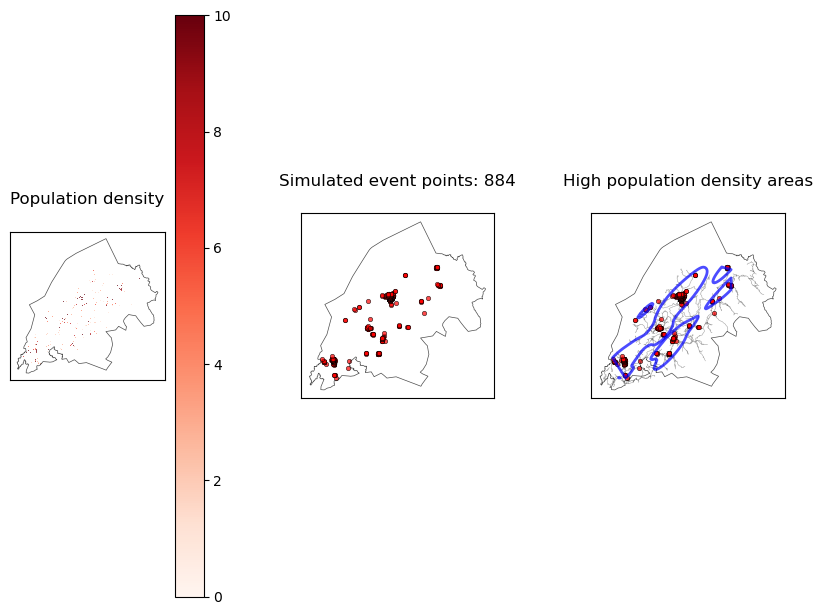

In [14]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Troms_polygon_gdf, population_gdf, event_points_gdf,
                                                                high_pop_density_area, edges, set_vmax=10)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [15]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Troms/TromsNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

,y,x,street_count,lon,lat,highway,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,,
5795532316,7631157.736,692311.830,3,19.753,68.725,NaN,POINT (692311.830 7631157.736),0.000,0.000
5795556879,7637342.199,689844.701,3,19.704,68.782,NaN,POINT (689844.701 7637342.199),0.000,34658.000


### 2.2 Sample candidate points and filter out best candidate points

In [16]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 150

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 8673, nr of police car nodes: 150


,y,x,street_count,lon,lat,highway,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,,
5773021648,7694248.618,670990.369,3,19.338,69.303,NaN,POINT (670990.369 7694248.618),0.000,34658.000
5871446436,7707641.514,622957.133,1,18.140,69.450,NaN,POINT (622957.133 7707641.514),0.000,0.000


Input nr of car nodes: 150
Remaining nr of car nodes: 143, after discarding the 7 (5%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


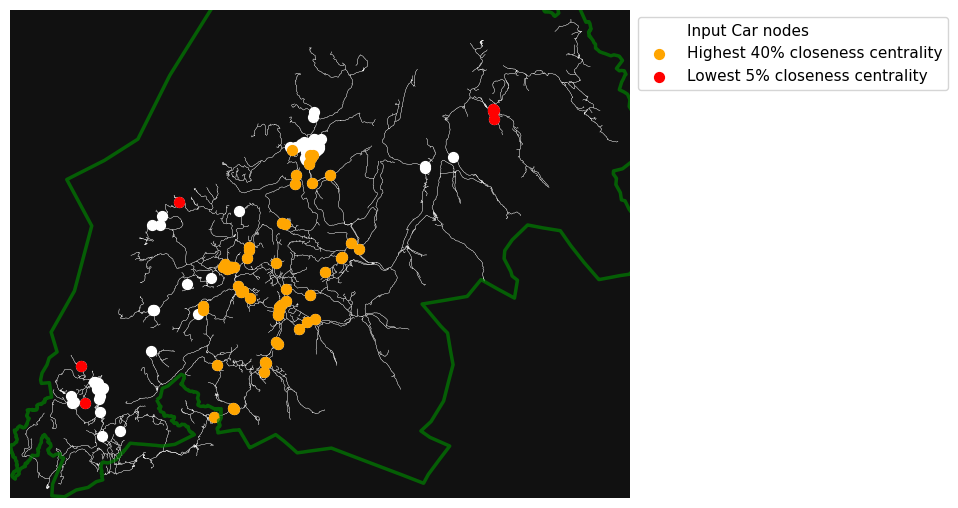

In [17]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Troms_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.05, input_graph=Troms_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 143
Remaining nr of car nodes: 86, after discarding the 57 (40%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


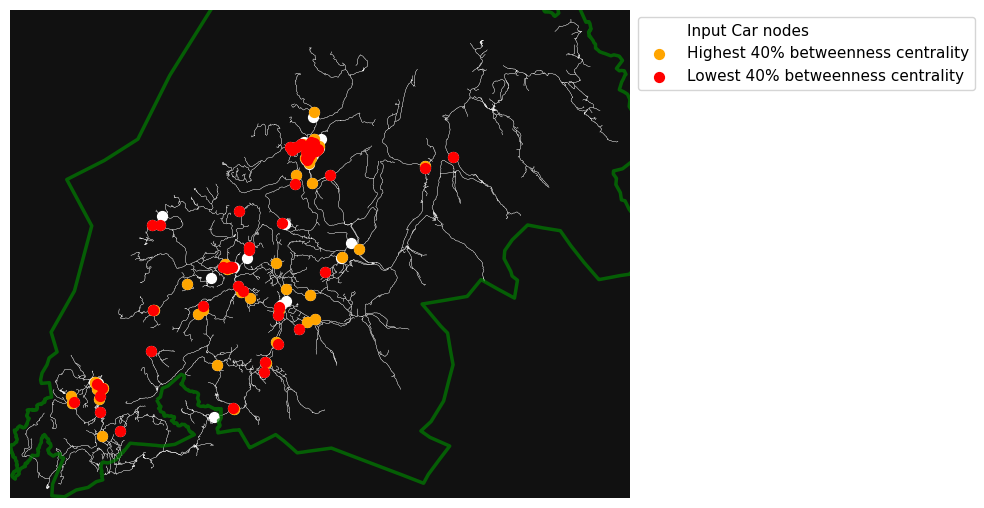

In [18]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Troms_polygon_gdf, 
                        top_percent=0.4, bottom_percent=0.40, input_graph=Troms_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 86
Remaining nr of car nodes: 30, after removing the 56 nodes that are within 6000 m of each other



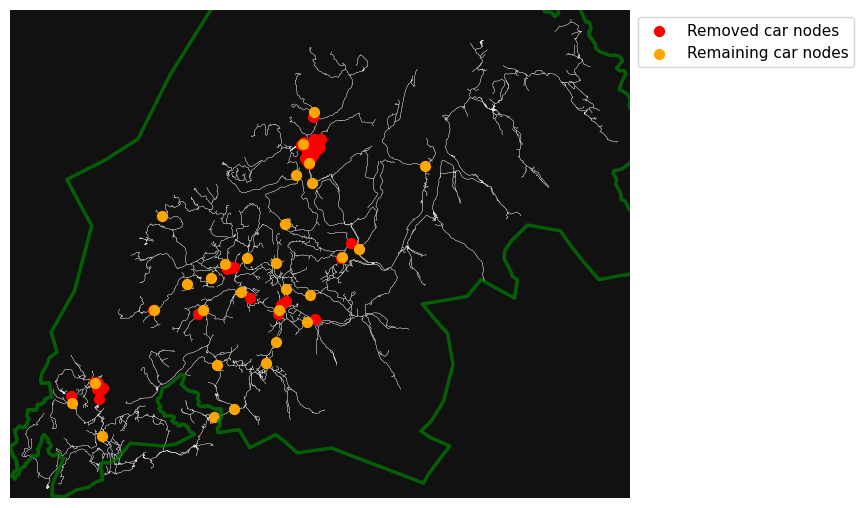

In [19]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Troms_polygon_gdf, 
                        min_distance=6000, input_graph=Troms_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [20]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
Troms_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Troms_network_pdna: {type(Troms_network_pdna)}")
print(f"Network nodes:")
Troms_network_pdna.nodes_df.head(2)

type of Troms_network_pdna: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
5795532316,692311.830,7631157.736
5795556879,689844.701,7637342.199


In [21]:
print(f"Network edges: ")
Troms_network_pdna.edges_df.head(2)

Network edges: 


,from,to,length,travel_time
0,5795532316,5795556879,6955.885,493.964
1,5795532316,5795532316,194.564,13.817


Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network. Therefore, we need to snap the event points to the Pandana network.

In [22]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Troms_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

,geometry,nearest_node,x,y
0,POINT (566814.904 7603956.484),5787003003,566660.801,7603924.302
1,POINT (564644.663 7608750.043),5787029840,564697.182,7608746.700


In [23]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Troms_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Troms_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([5795550445, 5768066165, 5056043583, 4159438914, 4412388901],
      dtype=int64)

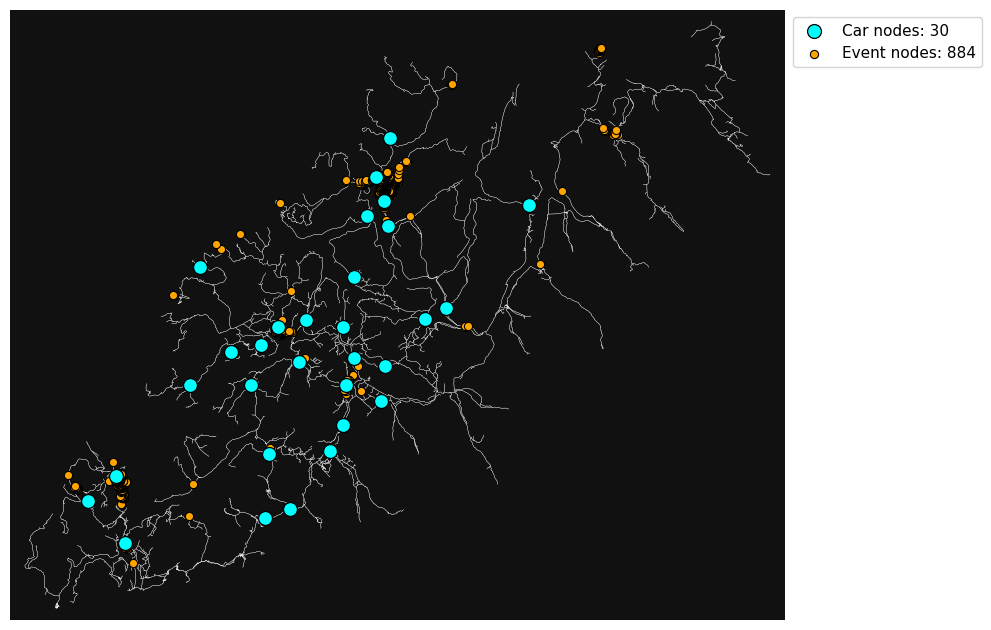

In [24]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Troms_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# travel time between each possible pair of car-event combination
distances = Troms_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Troms_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

30 origins x 884 destinations = 26520 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [142467.28, 149751.685, 150326.105, 150152.3, 150692.887]
5 first origin-destination travel times [sec]: [5320.684, 5656.142, 5700.654, 5671.768, 5714.017]
CPU times: total: 703 ms
Wall time: 161 ms


In [27]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,26520.000,96.508,52.058,0.000,59.164,97.242,126.734,259.369


In [28]:
# Restructure the distances and travel times arrays into a DataFrame (CTroms Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head(2) # distances, travel times, car and event node ids

,distance,travel_time,carNodeID,eventNodeID
0,142467.280,5320.684,5795550445,5787003003
1,149751.685,5656.142,5795550445,5787029840


In [29]:
# Merge the CostMatrix with the nodes DataFrame to get the x, y coordinates of the car and event nodes
# The 'osmid' column in the nodes DataFrame is the same as the 'carNodeID' and 'eventNodeID' columns in the CostMatrix
nodes_flat = nodes.reset_index()
CostMatrix_extended = CostMatrix.copy()
CostMatrix_extended = CostMatrix_extended.merge(nodes_flat[['osmid', 'x', 'y']], left_on='carNodeID', right_on='osmid')
CostMatrix_extended = CostMatrix_extended.merge(nodes_flat[['osmid', 'x', 'y']], left_on='eventNodeID', right_on='osmid', suffixes=('_car', '_event'))
CostMatrix_extended.drop(columns=['osmid_car', 'osmid_event'], inplace=True)
CostMatrix_extended.head(2)

,distance,travel_time,carNodeID,eventNodeID,x_car,y_car,x_event,y_event
0,142467.280,5320.684,5795550445,5787003003,642962.588,7674456.665,566660.801,7603924.302
1,149751.685,5656.142,5795550445,5787029840,642962.588,7674456.665,564697.182,7608746.700


In [65]:
# Save cTroms matrix to CSV
CostMatrix.to_csv("../data/Troms/TromsCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [66]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

,travel_time,carNodeID,eventNodeID
0,5312.703,5795586154,5787003003_1
1,5656.515,5795586154,5787012315_1


In [85]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
# margin = len(event_nodes_pdna) * 0.03 # 3% of all events
# CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
CAR_CAPACITY = 300
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 300 events per car
Filtering out 0% highest travel times - keeping only travel times <= 15260 sec, or 254.3 min
Original nr of pairs: 22984 | Filtered nr of pairs: 22984
Original max travel time: 15260.248 | Filtered max travel time: 15260.248


### 5.2 Setup LP problem

In [86]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 26
Number of events: 884
Number of decision variables: 23010
Number of constraints: 23895
Number of non-zero coefficients: 23010
Number of non-zero coefficients in the objective function: 22983
CPU times: total: 750 ms
Wall time: 1.27 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [87]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 2/4 locations in 1.88 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 8.88 seconds: [5795586154 5861989038 4042896148 5760340834]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 841075.5290 seconds, or 14017.93 minutes, or 233.63 hours
CPU times: total: 2.81 s
Wall time: 13.3 s


### 5.6 Extract results for inspection

In [88]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/Troms/TromsCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([5795586154, 5861989038, 4042896148, 5760340834])
Car 5795586154 is assigned 140/300 events
Car 5861989038 is assigned 300/300 events
Car 4042896148 is assigned 178/300 events
Car 5760340834 is assigned 266/300 events
Summing the events for each car gives 884 events, which should equal the total number of unique events: 884


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 26 | Optimal locations in solution: 4
- Events: 884 | Max event capacity per police car: 300

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 841076 sec | 14017.9 min | 233.63 hours

Car id: 5795586154 handles 140 events | Capacity: 46.67% | Total response time: 7165.75 min | Median: 26.25 min | Avg: 51.18 min
Car id: 5861989038 handles 300 events | Capacity: 100.00% | Total response time: 2387.64 min | Median: 8.21 min | Avg: 7.96 min
Car id: 4042896148 handles 178 events | Capacity: 59.33% | Total response time: 904.99 min | Median: 3.53 min | Avg: 5.08 min
Car id: 5760340834 handles 266 events | Capacity: 88.67% | Total response time: 3559.55 min | Median: 12.84 min | Avg: 13.38 min


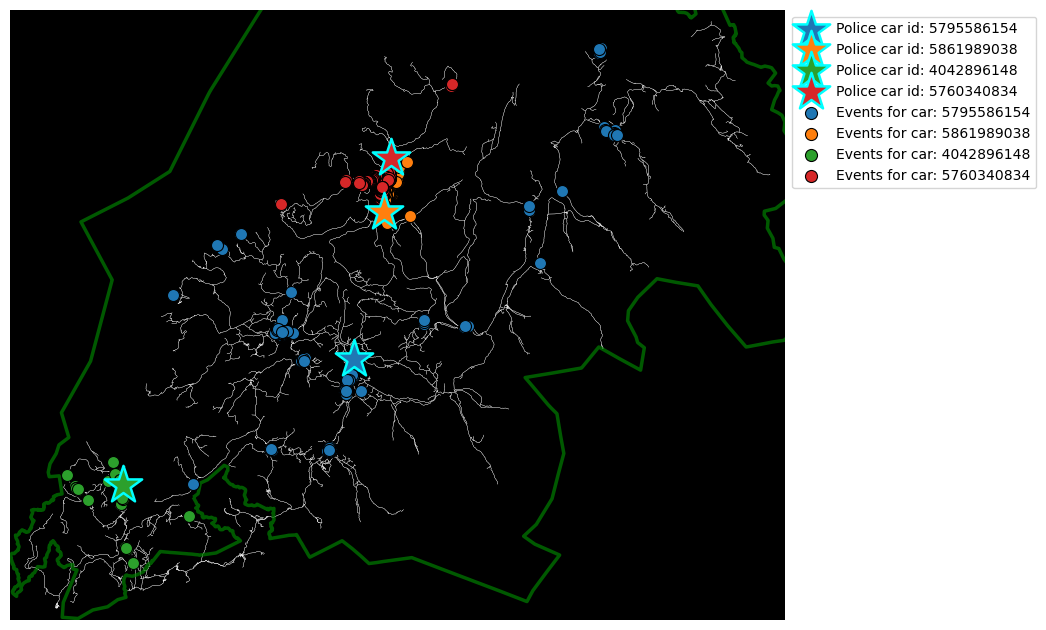

CPU times: total: 1.59 s
Wall time: 2.07 s


In [89]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(Troms_graph, Troms_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                        car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [94]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [95]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Troms_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=500, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 26.8 s
Wall time: 31.5 s


Isochrone polygons for the travel times: [20, 60, 120] minutes


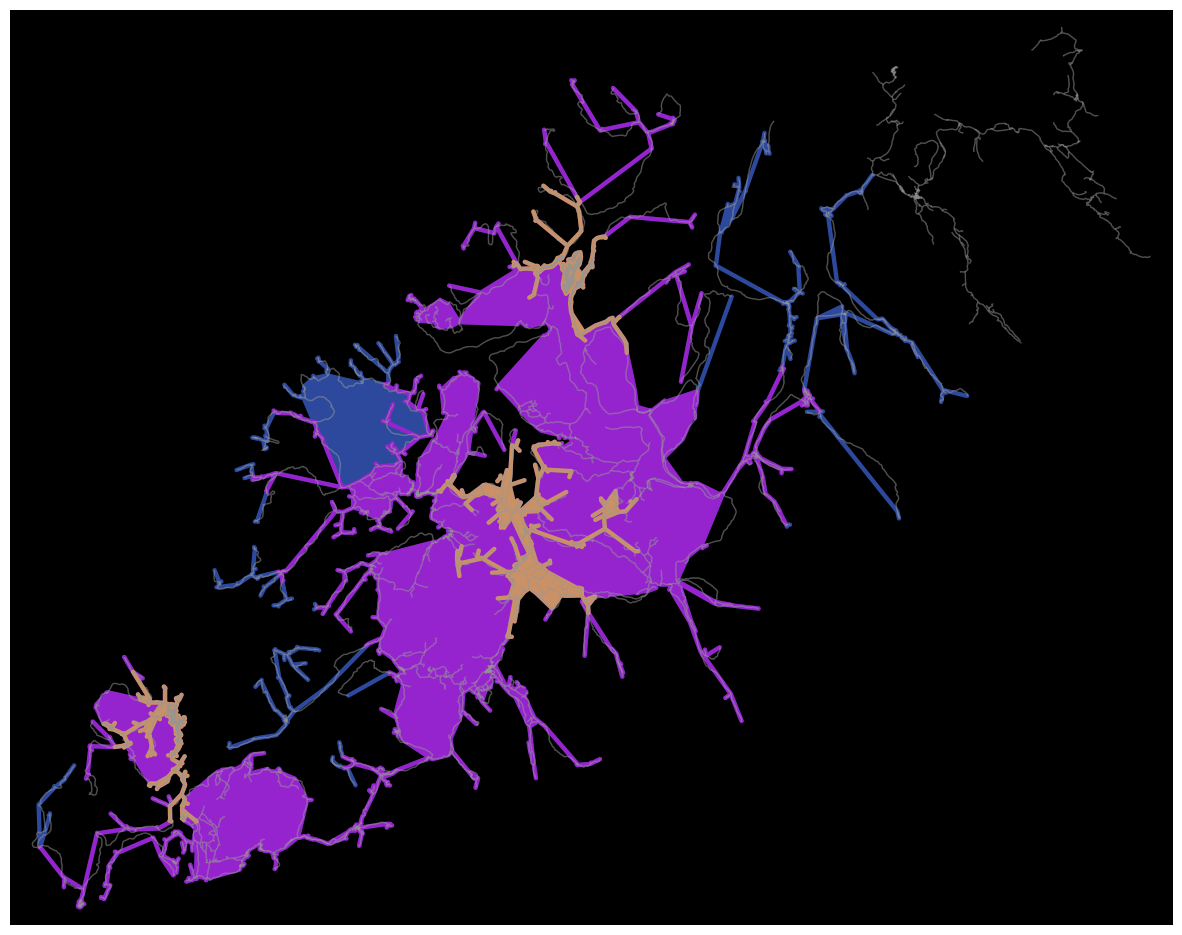

In [96]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Troms_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [97]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Troms_graph_increased, TRIP_TIMES, merged_isochrones, Troms_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 297 ms
Wall time: 366 ms
